# Overview

Here, we'll see how to define a `Kork` CodeChain that can invoke external python functions.

In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import langchain
from langchain.llms import OpenAI

from kork import CodeChain

## Foreign Functions

Let's create a list of python functions that we want the chain to be able to invoke.

Information about these functions will be added into the prompt to let the LLM know it can use them.

The functions will also be added as foregin functions into the kork interpreter environment, so the interpreter can actually use them!

In [13]:
def output_with_matplotlib(output: str) -> None:
    """Function that will output a plot using matplotlib."""
    if not isinstance(output, str):
        raise ValueError("LLM failed to produce a string!")

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    ax.axis("off")
    ax.text(0.5, 0.5, output, ha="center", va="center")
    plt.show()

In [14]:
def foo(what_to_print: str) -> str:
    """A function that something to the screen"""
    print("Invoking a custom user defined function")
    try:
        import matplotlib

        output_with_matplotlib(what_to_print)
    except ImportError:
        print("Matplotlib missing so using print")
        print(what_to_print)
    print("Finished invoking a custom user defined function")

In [15]:
import math

In [16]:
foreign_functions = [foo, math.pow, math.log2, math.log10, math.sqrt]

## Examples

Use examples to teach the llm how to work in the target problem domain. Later in the docs, we'll see how to customize the entire prompt.

If the programs invoke functinos, make sure that the function names match exactly the names of the foreign functions provided (no validation here currently).

We can specify the programs in text format.

In [17]:
examples = [
    ("calculate the sqrt of 2", "let result = pow(2, 0.5)"),
    ("2*5 + 1", "let result = 2 * 5 + 1"),
    ("1.3e-3", "let result = 1.3 * pow(10, -3)"),
    ("2**5", "let result = pow(2, 5)"),
    ("calculate log of 2", "let result = log2(2)"),
    ("set the value of result to the string hello", 'let result = "hello";'),
    (
        "every day i eat 3 donuts. how many donuts do i eat during the week",
        "let days_in_week = 7; let result = days_in_week * 3;",
    ),
]

But before we can feed them into the chain, we need to convert them into an abstract syntax tree (ast):

In [18]:
from kork.parser import parse

examples_in_ast = [(query, parse(code)) for query, code in examples]

Now the first example is composed of a 2-tuple of query and a corresponding program expressed in `Kork` AST.

In [19]:
examples_in_ast[0]

('calculate the sqrt of 2',
 Program(stmts=(VarDecl(name='result', value=FunctionCall(name='pow', args=(Literal(value=2), Literal(value=0.5)))),)))

## CodeChain

The inputs into the chains will be explained in detail later in the documentation.

For now, let's run the code chain and look at the generated prompt and the output from the chain!

In [22]:
llm = OpenAI(
    model_name="text-davinci-003",
    temperature=0,
    max_tokens=2000,
    frequency_penalty=0,
    presence_penalty=0,
    top_p=1.0,
    verbose=True,
)

chain = CodeChain.from_defaults(
    llm=llm,
    examples=examples_in_ast,
    context=foreign_functions,
)

Let's see if we can the LLM to invoke our print function?

Invoking a custom user defined function


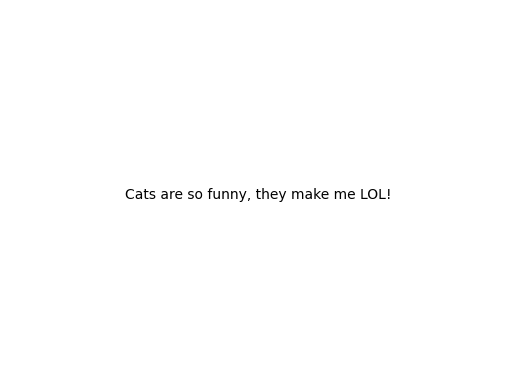

Finished invoking a custom user defined function


In [23]:
code_result = chain(
    inputs={
        "query": "write a program to output a funny sentence about a cat to the screen"
    }
)

---------

Here's the code that was written by the LLM.

In [24]:
from kork.display import display_code_result

In [25]:
display_code_result(code_result, columns=["query", "code"])

,query,code
0,write a program to output afunny sentence about a cat tothe screen,"var result = foo(""Cats are so funny, they make me LOL!"")"


```{hint}
The LLM successfully invoked a custom user function called `foo` which printed to the screen. 🤔

Feel free to experiment and create functions that create images, play sounds etc. 

The chain will be able to invoke any functions that you provide it.
```

```{note}

The LLM may return `var result = 0` at the end of the program.

The examples and prompt bias it to end in a variable declaration statement.

The prompt and examples can be customized to change this behavior.
```

```{caution}

You may see failures even in simple tasks like this one. See the guidelines section.
```

## The prompt

Let's turn on verbose mode and take a look at the prompt that gets generated.

In [26]:
langchain.verbose = True

And let's try a more complex sentence.

In [27]:
query = "An ecoli cell doubles every 30 mins in a test tube. How long will it take 1 cell to become 16 cells? Use variable declarations and function invocations."

code_result = chain(inputs={"query": query})



> Entering new LLMChain chain...
Prompt after formatting:
You are programming in a language called "😼".

You are an expert programmer and must follow the instructions below exactly.

Your goal is to translate a user query into a corresponding and valid 😼
program.

You have access to the following external functions:

```😼
extern fn foo(what_to_print: str) -> str // A function that something to the screen
extern fn pow(x: Any, y: Any) -> Any // Return x**y (x to the power of y).
extern fn log2(x: Any) -> Any // Return the base 2 logarithm of x.
extern fn log10(x: Any) -> Any // Return the base 10 logarithm of x.
extern fn sqrt(x: Any) -> Any // Return the square root of x.
```


Do not assume that any other functions except for the ones listed above exist.

Wrap the program in <code> and </code> tags.

Store the solution to the query in a variable called "result".

Here is a sample valid program:

<code>
var x = 1 # Assign 1 to the variable x
var result = 1 + 2 # Calculate the sum of 

The llm output was:

In [28]:
display_code_result(code_result, expected_answer=120.0)

,query,code,result,expected,correct,errors,raw
0,An ecoli cell doubles every 30mins in a test tube. How longwill it take 1 cell to become16 cells? Use variabledeclarations and functioninvocations.,var cell_count = 1var target_cell_count = 16var doubling_time = 30var result = log2(target_cell_count / cell_count) * doubling_time,120.0,120.0,✅,[],<code>var cell_count = 1var target_cell_count = 16var doubling_time = 30var result = log2(target_cell_count / cell_count) * doubling_time</code>


## The Environment

After running the chain, we have access to state of the environment after the interpreter finished running the code.

We can fetch the `result` variable from the environment.

In [29]:
type(code_result["environment"])

kork.environment.Environment

The result of the calculation for the e-coli cell is stored in the `result` symbol

In [30]:
print(code_result["environment"].get_symbol("result"))

120.0


## Relativistic Kinetic Energy

We can try to carry out a more complex physics calculation.

```{important}

LLMs can struggle with longer and more complex tasks.

Guidelines:

1. Use a better LLM
2. Customize the prompt for your task
3. Provide examples
4. Provide foreign functions that are simple and include type annotations and short doc-strings.
```

```{attention}

`Kork` is very much a work in progress. 

It's not yet doing a 2nd pass with an LLM to help correct bugs in the generated program, which
will likley help improve results.
```

In [31]:
query = """\
Let's calculate the kinetic energy of a relativistic electron moving at 0.9999c in MeV. 
First list all relevant physical constants and conver them into an appropriate units.
Now, calculate the lorentz factor.
Then subtract one from it, and multiply the result by the rest mass of an electron in MeV.
Make sure to use the listed foreign functions and no binary arithemtic operators."""

code_result = chain(inputs={"query": query})



> Entering new LLMChain chain...
Prompt after formatting:
You are programming in a language called "😼".

You are an expert programmer and must follow the instructions below exactly.

Your goal is to translate a user query into a corresponding and valid 😼
program.

You have access to the following external functions:

```😼
extern fn foo(what_to_print: str) -> str // A function that something to the screen
extern fn pow(x: Any, y: Any) -> Any // Return x**y (x to the power of y).
extern fn log2(x: Any) -> Any // Return the base 2 logarithm of x.
extern fn log10(x: Any) -> Any // Return the base 10 logarithm of x.
extern fn sqrt(x: Any) -> Any // Return the square root of x.
```


Do not assume that any other functions except for the ones listed above exist.

Wrap the program in <code> and </code> tags.

Store the solution to the query in a variable called "result".

Here is a sample valid program:

<code>
var x = 1 # Assign 1 to the variable x
var result = 1 + 2 # Calculate the sum of 

In [32]:
expected_answer = 0.511 * ((1 - 0.9999**2) ** (-0.5) - 1)

```{caution}

Success rate of this calculation is higher than 5%, but definitely lower than 80%. Huge variation due to underlying LLM!

This is a cherry picked run when things work as expected. A 2nd pass with an LLM may be needed to get more robust.
```

In [33]:
display_code_result(code_result, expected_answer=expected_answer)

,query,code,result,expected,correct,errors,raw
0,"Let's calculate thekinetic energy of arelativistic electron movingat 0.9999c in MeV. First listall relevant physicalconstants and conver them intoan appropriate units. Now,calculate the lorentz factor.Then subtract one from it, andmultiply the result by therest mass of an electron inMeV. Make sure to use thelisted foreign functions andno binary arithemticoperators.","var c = 299792458 // Speed of light in m/svar rest_mass_electron = 0.511 // Rest mass of an electron in MeVvar speed = 0.9999 * c // Speed of the electron in m/svar lorentz_factor = 1 / sqrt(1 - pow(speed, 2) / pow(c, 2)) // Calculate the lorentz factorvar result = (lorentz_factor - 1) * rest_mass_electron // Calculate the kinetic energy in MeV",35.62305988140826,35.62305988142832,✅,[],"<code>var c = 299792458 // Speed of light in m/svar rest_mass_electron = 0.511 // Rest mass of an electron in MeVvar speed = 0.9999 * c // Speed of the electron in m/svar lorentz_factor = 1 / sqrt(1 - pow(speed, 2) / pow(c, 2)) // Calculate the lorentz factorvar result = (lorentz_factor - 1) * rest_mass_electron // Calculate the kinetic energy in MeV</code>"


## Calculations with LLMs

As LLMs get better and better they will better approximate the correct answer (without having to even specify an algorithm).

You can try this exercise with GPT-4 or chat gpt. With an appropriate prompt and model, the results can look pretty reasonable!

Alternatively, you can compare the results with langchain math chains!

As an experiment, you could use an LLM to generate a calculation plan for a given scientific question and then use a code chain to translate the instructions into a program.


```{caution}

Similarily to humans it looks like the LLMs can struggle a bit with unit conversions. 😹

But the knowledge is there, so maybe we just need to be clever enough!
```

In [35]:
print(
    llm.generate(
        prompts=[
            "What is the relativistic kinetic energy of an electron moving at 0.999999 c expressed in MeV?"
        ]
    )
    .generations[0][0]
    .text
)



The relativistic kinetic energy of an electron moving at 0.999999 c is 7.979 MeV.


In [36]:
print(
    llm.generate(
        prompts=[
            "What is the relativistic kinetic energy of an electron moving at 0.9999 c expressed in MeV explain step by step calculation?"
        ]
    )
    .generations[0][0]
    .text
)



The relativistic kinetic energy of an electron moving at 0.9999 c can be calculated using the equation:

KE = (γ - 1)mc2

Where γ is the Lorentz factor, m is the mass of the electron, and c is the speed of light.

Step 1: Calculate the Lorentz factor

γ = 1/√(1 - v2/c2)

γ = 1/√(1 - (0.9999)2)

γ = 1/√(1 - 0.99980001)

γ = 1/√(0.00019999)

γ = 1/0.0141

γ = 70.7107

Step 2: Calculate the relativistic kinetic energy

KE = (γ - 1)mc2

KE = (70.7107 - 1)mc2

KE = 69.7107mc2

KE = 69.7107 x (9.109 x 10-31 kg) x (3 x 108 m/s)2

KE = 1.945 x 10-13 J

Step 3: Convert Joules to MeV

1 MeV = 1.602 x 10-13 J

KE = 1.945 x 10-13 J / 1.602 x 10-13 J/MeV

KE = 1.21 MeV


In [37]:
print(
    llm.generate(
        prompts=[
            "Generate step by step instructions to calculate the relativistic kinetic energy of an electron moving at 0.9999c?"
        ]
    )
    .generations[0][0]
    .text
)



1. Determine the speed of the electron in terms of the speed of light (c). In this case, the electron is moving at 0.9999c.

2. Calculate the relativistic factor (γ) using the equation γ = 1/√(1-v2/c2).

3. Calculate the relativistic kinetic energy (Ek) using the equation Ek = γmc2 - mc2.

4. Substitute the values for γ and c into the equation and solve for Ek.
